![banner](../img/cdips_2017_logo.png)

# Neural Network Regression

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import scripts.load_data as load

import seaborn as sns
sns.set(font_scale=2)

%matplotlib inline

In [2]:
import sklearn.decomposition
import sklearn.random_projection
import sklearn.neural_network
from sklearn.model_selection import train_test_split

In [3]:
X, y  = load.load_training_spectra()

[Neural networks](http://pages.cs.wisc.edu/~dyer/cs540/handouts/deep-learning-nature2015.pdf)
are a powerful and flexible tool for solving problems
ranging from
[data science](http://www.oreilly.com/pub/e/2538)
to
[artificial intelligence](https://en.wikipedia.org/wiki/AlphaGo).

There are many different kinds of neural networks,
but we'll be focusing on
*feedforward neural networks*,
also known as
[multilayer perceptrons](http://scikit-learn.org/stable/modules/neural_networks_supervised.html).

The online book
[Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)
is a great resource for folks
with less background in mathematics and statistics,
while the online book
[Deep Learning](http://www.deeplearningbook.org/)
is more authoritative and thorough,
but requires more background.

If you'd just like to see some neural networks in action
on some visualizable datasets,
check out Google's
[Neural Network Playground](http://playground.tensorflow.org/).

## Defining Neural Networks

The idea behind neural networks is simple:
we linearly transform our input,
$\mathbf{x}$,
using a matrix, $\text{W}$,
and then apply a nonlinear function $f$
to get values we call the
*activations*, $\mathbf{a}$:

$$
\mathbf{a} = f(\text{W}\mathbf{x})
$$

These activations can then be passed through another combination
of linear and nonlinear transformation,
as can those resulting activations.

At some point, we compare some final set of activations $\hat{y}$
to some target value $y$
using a cost function,
just as we do in other models.

We then calculate how much the cost function changes if we
change each of the values in the various matrices $\text{W}$.
This change is called the *gradient*
and the algorithm used to calculate the gradients
is called
[backpropagation](http://colah.github.io/posts/2015-08-Backprop/).

This setup was
[inspired by the architecture of the brain](https://mitpress.mit.edu/books/parallel-distributed-processing).
In the brain,
cells called neurons
receive inputs,
either from sensors of the outside world
or from other neurons,
which are combined with varying weights
and then nonlinearly transformed
before being passed on to other neurons.

## Training Neural Networks

Despite the simplicity of the linear-nonlinear transformation,
neural networks are capable of
[implementing any function on their inputs](http://neuralnetworksanddeeplearning.com/chap4.html).

This makes them capable of extreme over-fitting,
especially on small datasets like ours.

To avoid this, we made hyper-parameter choices
that would discourage over-fitting.
Here are a few of them:

- **Weight Decay** - Weight decay is identical to what is called, for other models,
[$\ell^2$ regularization](link).
Weight decay encourages weight values to be small, which can prevent over-fitting solutions,
which tend to have high weights.
- **Small Minibatches** - Instead of using the entire training set (also called a *batch*) to calculate the current performance and the gradient, we use a very small subset, also called a *minibatch*. This makes the gradient less reliable, but it also makes it harder for the network to fit the training set perfectly. Intuitively, only patterns that are generally useful will show up in every minibatch and so in every gradient, while patterns that are useful for only a small subset of the data will show up infrequently and cancel each other out.

Using the heuristic of trying to avoid over-fitting,
we tried, by hand,
a number of different hyperparameter settings.

The cells below train a neural network
with these hand-selected hyperparameters
and display its performance.

### Hand-Tuned Model

In [4]:
handtuned_model = sklearn.neural_network.MLPRegressor(activation = 'relu',
                                                     batch_size = 16,
                                                     hidden_layer_sizes = (100),
                                                     learning_rate_init = 0.0001,
                                                     max_iter = 10000,
                                                     tol = 1e-8)

In [5]:
linear_model = sklearn.linear_model.LinearRegression()

In [6]:
def crossvalidate_performance(model, X, y, num_splits = 20):

    train_scores = np.zeros(num_splits)
    test_scores = np.zeros(num_splits)

    for split_idx in range(num_splits):

        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,)

        PCA_transform = sklearn.decomposition.PCA(n_components=100).fit(X_train)

        transformed_X_train = PCA_transform.transform(X_train)
        transformed_X_test = PCA_transform.transform(X_test)

        model.fit(transformed_X_train, y_train)

        train_scores[split_idx] = model.score(transformed_X_train, y_train)
        test_scores[split_idx] = model.score(transformed_X_test, y_test)
        
    return train_scores, test_scores

In [7]:
byhand_train, byhand_test = crossvalidate_performance(handtuned_model, X, y, num_splits=10)

In [8]:
linear_train, linear_test = crossvalidate_performance(linear_model, X, y, num_splits=10)

In [9]:
def display_performance(model_name, train_scores, test_scores):
    means = [np.mean(train_scores), np.mean(test_scores)]
    stds = [np.std(train_scores), np.std(test_scores)]
    
    plt.errorbar([0,1], means, yerr=stds,
            linewidth=4,label=model_name)
    plt.xticks([0,1], ['Training', 'Test'])
    plt.ylim([0,1]); plt.ylabel(r'$R^2$');
    plt.xlim([-0.5,1.5])
    plt.legend()

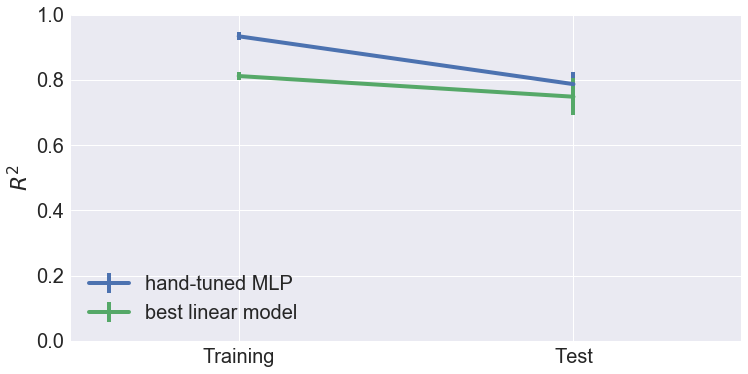

In [10]:
plt.figure(figsize=(12,6))
display_performance('hand-tuned MLP', byhand_train, byhand_test) 
display_performance('best linear model', linear_train, linear_test) 

This is decent performance, but it's likely we can do better!

Instead of selecting hyperparameters by hand
and trying new values guided by heuristics,
we can perform a search.

scikit-learn implements
[several search methods](http://scikit-learn.org/stable/modules/grid_search.html).
Unfortunately,
there are no methods that
[unequivocally perform better](http://www.argmin.net/2016/06/20/hypertuning/)
than the simplest ones:
selecting feasible values for each hyperparameter
and then checking all combinations,
also known as
[grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
or checking random values for each hyperparameter
within some feasible range,
also known as
[random search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

Most folks use random search,
as we do in
[this notebook](05_A - Gradient Boosted Regression Trees - Single Target.ipynb).
To be complete,
we here use grid search instead.

Performing a cross-validated grid search
across all of the hyperparameters for a neural network
takes a very long time.
In fact, the time grows multiplicatively with each
added hyperparameter:
if it takes 4 minutes to check all combinations of two hyperparameters
that take on just two different values (e.g `True` or `False`),
then it takes 8 minutes to check all combinations if we add on another binary hyperparameter.

The grid search that was performed for this model required testing
around 2500
different networks.
Each had to be fit to 3 different cross-validation folds in order to get
an estimate of the test-set performance,
so the search required the training of
roughly 7500
neural networks.

On a consumer laptop, this took over a day.
In industrial settings,
the amount of computing power available is generally greater,
but so is the model complexity and dataset size,
so search times of days or weeks are not uncommon.

The results of a scikit-learn grid search are stored
in a pandas DataFrame.
Our results are saved as a `.csv` file
in `data/model_params/GridSearch_07262017.csv`.

More detail on these results can be found in the
[GridSearchCV for Neural Networks](04_B - GridSearchCV for Neural Networks.ipynb)
notebook.

The cells below produce a cross-validated performance plot
for the best setting of the hyperparameters
that came out of that grid search.

Because the definition of "best" is underdetermined,
we present two of the networks uncovered by this
search process.

One is the model with the best performance
on the test set.
However, our
[close analysis of the grid search results](04_B - GridSearchCV for Neural Networks.ipynb)
determined that some of the best perfomers on the test set had
substantial gaps between their test and train error,
also known as *generalization error*.
A high generalization error with an internally split train/test
set bodes ill for the generalization error on newly-collected data,
since novel test data is likely to be even more different from the training set
than the artificially-created test data.

### Grid-Search Optimized Models

In [11]:
best_test_model = sklearn.neural_network.MLPRegressor(activation = 'relu',
                                                     alpha = 0.0001,
                                                     batch_size = 16,
                                                     beta_1 = 0.9,
                                                     beta_2= 0.99,
                                                     early_stopping = False,
                                                     hidden_layer_sizes = 100,
                                                     learning_rate_init = 0.0001,
                                                     max_iter = 10000,
                                                     tol = 1e-16)

In [12]:
best_test_train, best_test_test = crossvalidate_performance(best_test_model, X, y, num_splits=10)

In [13]:
best_generalizer_model = sklearn.neural_network.MLPRegressor(activation = 'logistic',
                                                     alpha = 0.0001,
                                                     batch_size = 16,
                                                     beta_1 = 0.95,
                                                     beta_2= 0.99,
                                                     early_stopping = False,
                                                     hidden_layer_sizes = 100,
                                                     learning_rate_init = 0.0001,
                                                     max_iter = 10000,
                                                     tol = 1e-16)

In [14]:
best_generalizer_train, best_generalizer_test = crossvalidate_performance(best_generalizer_model,
                                                                          X, y, num_splits=10)

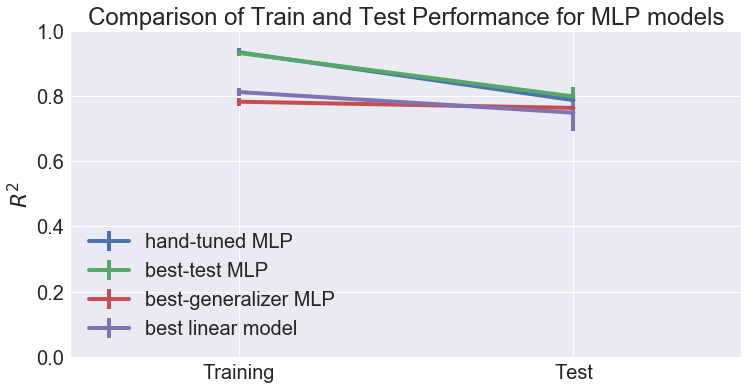

In [15]:
plt.figure(figsize=(12,6))
display_performance('hand-tuned MLP', byhand_train, byhand_test)
display_performance('best-test MLP', best_test_train, best_test_test)
display_performance('best-generalizer MLP', best_generalizer_train, best_generalizer_test)
display_performance('best linear model', linear_train, linear_test) 
plt.title(r'Comparison of Train and Test Performance for MLP models');

Interestingly, we don't get a huge
boost in performance on the test set from
our grid search.

A random search might be able to find a better setting of the parameters,
but the
[results of our grid search](04_B - GridSearchCV for Neural Networks.ipynb)
and the
Kaggle leaderboard
seem to indicate that substantially better performance isn't possible with this training set.

With this is mind, it seems that minimizing the gap between
training set performance and test set performance
seems like the best move,
but on that front the
[linear model](03 - Linear Regression.ipynb)
is quite competitive.